In [1]:
!pip install transformers
!pip install seaborn
import pandas as pd
import json
from transformers import pipeline

2023-03-20 23:22:01.924387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 23:22:02.134230: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
wording_pipe = pipeline('text-classification', model='tiedaar/summary-longformer-wording', function_to_apply="none", truncation=True)
content_pipe = pipeline('text-classification', model='tiedaar/summary-longformer-content', function_to_apply="none", truncation=True)

Some weights of the model checkpoint at tiedaar/summary-longformer-wording were not used when initializing LongformerForSequenceClassification: ['longformer.embeddings.position_ids']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at tiedaar/summary-longformer-content were not used when initializing LongformerForSequenceClassification: ['longformer.embeddings.position_ids']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another 

In [3]:
data = open('../data/source_dict.txt', 'r')
source_dict = json.loads(data.read())

In [4]:
def getScore(summary, chapter):
    text = summary + '</s>' + source_dict[chapter]
    pipe1 = pipeline('text-classification', model='tiedaar/summary-longformer-wording', function_to_apply="none")
    pipe2 = pipeline('text-classification', model='tiedaar/summary-longformer-content', function_to_apply="none")
    return pipe1(text)[0]['score'], pipe2(text)[0]['score']

In [5]:
df = pd.read_csv('../data/PCA_scores_itell.csv', index_col=[0]).reset_index()

In [6]:
df['chapter_section'] = df['section'].apply(lambda x: '01-'+str(x))

In [7]:
content = [content_pipe(row[1]['summary']+'</s>'+source_dict[row[1]['chapter_section']])[0]['score'] for row in df.iterrows()]
wording = [wording_pipe(row[1]['summary']+'</s>'+source_dict[row[1]['chapter_section']])[0]['score'] for row in df.iterrows()]

In [8]:
df['content'] = content
df['wording'] = wording

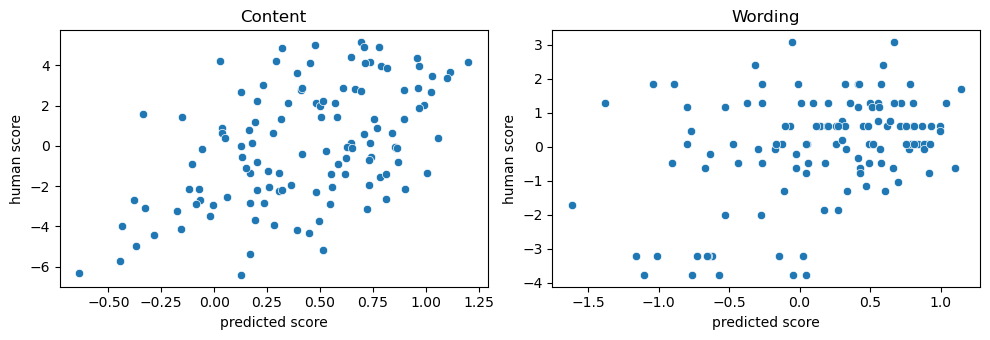

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax =plt.subplots(1,2)
plt.rcParams["figure.figsize"] = [10.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(data=df, x='content', y='Content_pca', ax=ax[0])
sns.scatterplot(data=df, x='wording', y='Wording_pca', ax=ax[1])
ax[0].set(xlabel='predicted score', ylabel='human score', title='Content')
ax[1].set(xlabel='predicted score', ylabel='human score', title='Wording')
plt.show()

array([[<AxesSubplot: title={'center': 'Content_pca'}>,
        <AxesSubplot: title={'center': 'Wording_pca'}>]], dtype=object)

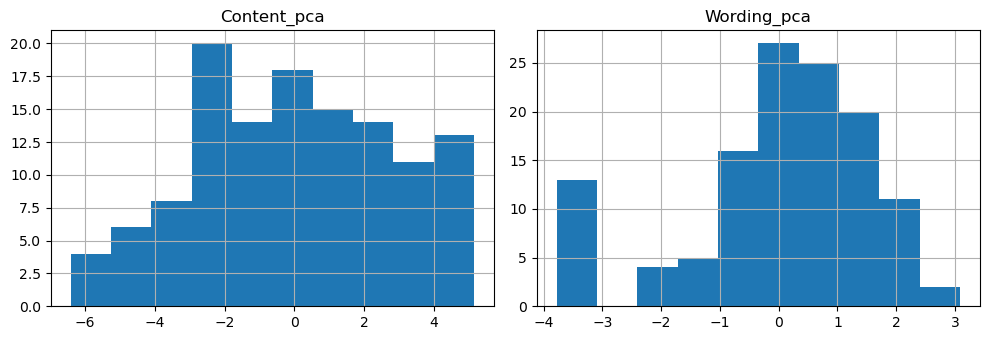

In [14]:
df[['Content_pca', 'Wording_pca']].hist()
